<a href="https://colab.research.google.com/github/erjank/563-a1/blob/main/debugging-mc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#Sampling, performance and system size
import numpy
directions = [numpy.array((1,0)),numpy.array((0,-1)),numpy.array((-1,0)),numpy.array((0,1))]
def pbc(site,L): #The convention here is to have positive lattice indices
  for i,s in enumerate(site):
    if s >= L:
      site[i] = s - L
    elif s < 0:
      site[i] = s + L
  return site

class grid():
  def __init__(self,N=5,L=4,T=1.0):
    self.L = L
    self.N = N
    self.epsilon = -1
    self.kT = T
    self.particles = []
    self.sites = numpy.zeros((L,L))
    for i in range(self.N):
      self.particles.append(particle())
      while True:
        rands = self.random_site()
        if not self.occupied(rands):
          self.particles[-1].location = rands
          self.sites[tuple(rands)] = 1 #occupied
          break
    self.E = self.energy()

  def occupied(self,site):
    if self.sites[tuple(site)] == 1:
      return True
    return False

#    for p in self.particles:
#      if numpy.array_equal(p.location,site):
#        return True
#    return False

  def random_site(self):
    return numpy.array((numpy.random.randint(self.L),numpy.random.randint(self.L)))

  def distance(self,site1,site2):
    return numpy.linalg.norm(site1-site2)

  def energy(self):
    energy = 0
    for p in self.particles:
      neighbors = p.get_neighbors(self.L)
      for n in neighbors:
        if self.occupied(n):
          energy += self.epsilon
    return energy/2

  def __repr__(self):
    m = numpy.zeros((self.L, self.L))
    for p in self.particles:
      m[tuple(p.location)] = 1
    return str(m)

class particle():
  def __init__(self):
    self.location = numpy.array((-1,-1)) #negative index means unplaced

  def get_neighbors(self,L):
    neighbors = []
    for d in directions:
      neighbors.append( pbc(d+self.location, L))
    return neighbors

  def local_energy(self,grid):
    neighbors = self.get_neighbors(grid.L)
    energy = 0
    for n in neighbors:
      if grid.occupied(n):
        energy += grid.epsilon
    return energy

class simulation():
  def __init__(self,N=5,L=3,T=1.,steps = 1000,seed=2):
    numpy.random.seed(seed)
    self.grid = grid(N,L,T)
    self.accepted = 0
    self.rejected = 0
    self.energies = numpy.zeros(steps)
    for i in range(steps):
      self.trial_move()
      self.energies[i] = self.grid.E/N

  def trial_move(self):
    p = numpy.random.choice(self.grid.particles)
    old = p.location
    oldE = p.local_energy(self.grid)
    trial = self.grid.random_site()
    if not self.grid.occupied(trial):
      p.location = trial
      self.grid.sites[tuple(trial)] = 1
      self.grid.sites[tuple(old)] = 0
      newE = p.local_energy(self.grid)
      dE = newE - oldE
      if numpy.random.rand() < numpy.exp(-dE/self.grid.kT):
        self.grid.E += dE
        self.accepted += 1
        return
    p.location = old #need to reject moves that are overlaps
    self.grid.sites[tuple(trial)] = 0
    self.grid.sites[tuple(old)] = 1
    self.rejected += 1


In [39]:
# Let's try out the first 3 exact solutions - the 3rd might be getting a little slow.
import time
answers = []
for (N,L) in [ (20,5), (80,10), (180,15)]:
  t1 = time.perf_counter()
  s = simulation(N=N,L=L,T=1.0,steps=10000, seed = numpy.random.randint(10000))
  t2 = time.perf_counter()
  print("\nN=",N,"seconds/simulation = {:.2f}".format(t2-t1))
  answers.append( (s.energies.mean(), s.energies.std()))
  print("N=",N,"average E: {:.2f} +/- {:.2f}" .format( answers[-1][0],answers[-1][1]))
#OK yeah, that 8 minutes for a 10k step simulation of 180 particles is gross.
#going larger than that is impractical for this homework.
# For the N=80 and N=180 we've basically got the same answer: -1.68 +/- 0.03, with
# slightly better precision for the 180
# For N=20 is borderline different. 1.67-0.02= 1.65 = 1.68-0.03: so the average -1.64
# in N=20 is just out of range of one standard deviation of the other two runs
# We can get more precise with student's t-tests later, but for now, I wouldn't
# go below N=80.
# and our precision is about 0.03 Energy/Particle units.


N= 20 seconds/simulation = 1.22
N= 20 average E: -31.49 +/- 16.84

N= 80 seconds/simulation = 2.21
N= 80 average E: -9.52 +/- 4.51

N= 180 seconds/simulation = 3.78
N= 180 average E: -5.38 +/- 2.16


In [37]:
# Part 1 - energy per particle for T=1.0, number density 0.8
# we have a 2D system with integer cells so let's find a good system size where
# we can get close to 0.8 = N/L/L
for l in range(30):
  print(l,0.8*l*l)
# OK, looks like (N,L) of (20,5), (80,10), (180,15), (320,20) are our first four exact
# solutions, and (13,4), (65,9), (67, 11) are pretty close


0 0.0
1 0.8
2 3.2
3 7.200000000000001
4 12.8
5 20.0
6 28.800000000000004
7 39.2
8 51.2
9 64.8
10 80.0
11 96.80000000000001
12 115.20000000000002
13 135.20000000000002
14 156.8
15 180.0
16 204.8
17 231.20000000000002
18 259.2
19 288.8
20 320.0
21 352.8
22 387.20000000000005
23 423.20000000000005
24 460.80000000000007
25 500.0
26 540.8000000000001
27 583.2
28 627.2
29 672.8000000000001


N= 80 average E: -1.73 +/- 0.00
N= 80 acceptance rate 0.01


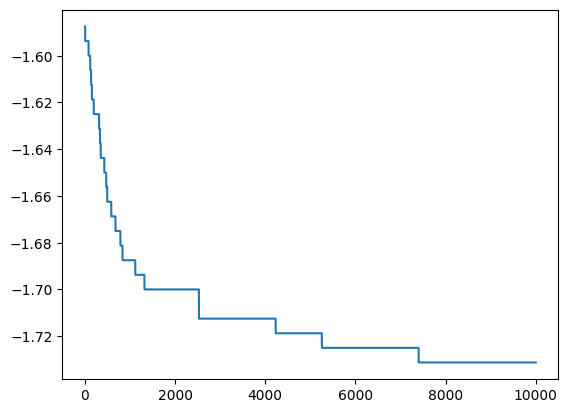

In [29]:
# Part 3, 5
import matplotlib.pyplot as plt
nsteps = 10000
s = simulation(N=80,L=10,T=0.05,steps=nsteps, seed = numpy.random.randint(10000))
plt.plot(s.energies)
print("N=",80,"average E: {:.2f} +/- {:.2f}" .format(s.energies[-200:].mean(),s.energies[-200:].std()))
print("N=",80,"acceptance rate {:.2f}".format(s.accepted/nsteps))
# Here we can't just average the whole run- The equilibrium distribution here is
# flat- can take the last 200 steps or so.
# For this particular run we got to -1.89 +/- 0.00,

N= 80 average E: -1.62 +/- 0.01
N= 80 acceptance rate 0.16


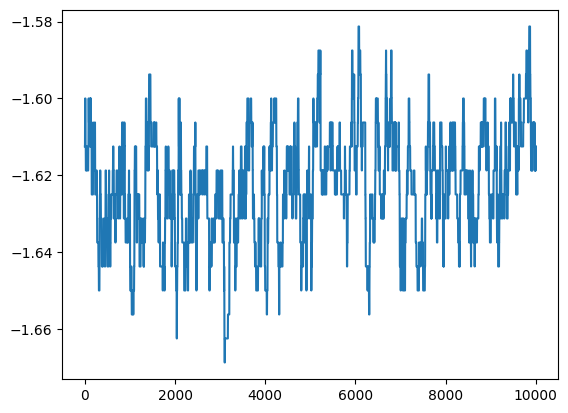

In [30]:
# Part 5
import matplotlib.pyplot as plt
nsteps = 10000
s = simulation(N=80,L=10,T=1.0,steps=nsteps, seed = numpy.random.randint(10000))
plt.plot(s.energies)
print("N=",80,"average E: {:.2f} +/- {:.2f}" .format(s.energies.mean(),s.energies.std()))
print("N=",80,"acceptance rate {:.2f}".format(s.accepted/nsteps))
# Ok, so the acceptance rate is 12% for T=1.0, and more like 1% for T=0.05
# One thing we see from this run is that we've got a lower average than before-
# This includes the 1.64 from the N=20 run from before- this tells us that maybe
# we need to be running longer, or maybe we can get away with N=20 at T=1.0.
# So let's answer this when we revisit problem 4 below- let's sweep over a bunch
# of system sizes from N=20-100 for longer jobs and have a look at the distributions
# we get:

In [31]:
#Part 4
import time
nsteps = 50000
results = {}
for L in range(3,12): #might take up to 40 min? go take a meeting!
  N = round(L*L*0.8)
  t1 = time.perf_counter()
  s = simulation(N=N,L=L,T=1.0,steps=nsteps, seed = numpy.random.randint(400))
  t2 = time.perf_counter()
  results[N] = (t2-t1, s.energies, s.accepted/nsteps)
  print("N=",N,"average E: {:.2f} +/- {:.2f}" .format(s.energies.mean(), s.energies.std()))
#Oh that's annoying- Above N=20 looks pretty close, but those smaller error bars at higher N
#might be real

N= 7 average E: -1.47 +/- 0.03
N= 13 average E: -1.62 +/- 0.03
N= 20 average E: -1.58 +/- 0.03
N= 29 average E: -1.64 +/- 0.02
N= 39 average E: -1.62 +/- 0.02
N= 51 average E: -1.60 +/- 0.02
N= 65 average E: -1.60 +/- 0.02
N= 80 average E: -1.60 +/- 0.02
N= 97 average E: -1.60 +/- 0.01


In [32]:
L = 15 # a perfect size, but a run will take longer than an hour
N = round(L*L*.8)
t1 = time.perf_counter()
s = simulation(N=N,L=L,T=1.0,steps=2*nsteps, seed = numpy.random.randint(400))# big long run
t2 = time.perf_counter()
results[N] = (t2-t1, s.energies, s.accepted/nsteps)

runtime for N= 180 243.36166985399905


-1.617501805555555

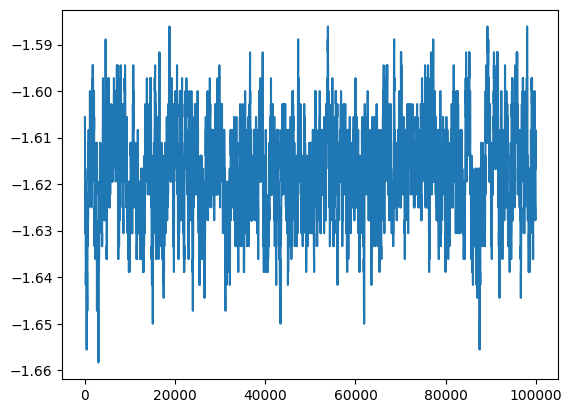

In [34]:
# can play with results[7], results[65][1], etc to get the results from N=7, or the energies
# from N=65, respectively.
N = round(15*15*.8)
plt.plot(results[N][1])
print("runtime for N=",N, results[N][0])
results[N][1].mean()

## Problem 1
**What is the average energy-per-particle for this system at a temperature of 1.0 energy units and a number density N/V=0.8?**

Note: The energy was already normalized at ``self.energies[i] = self.grid.E/N`` in the ``simulation`` constructor ``__init__()`` function, so lots of folks normalized by an extra ``N``.

**Answer:** Around -1.65. Depending on which system sizes you used and how long you ran, you might see some variance around this.   

## Problem 2
**How precise is your measurement, and is there an N below which you lose confidence in your answer?**

**Answer:** Well this is a little tricky, because it depends on running sufficiently long and sufficiently large to **gain** confidence in what the right answer is.

From the samples above with ``nsteps=50000``:
```
N= 7 average E: -1.53 +/- 0.06
N= 13 average E: -1.64 +/- 0.05
N= 20 average E: -1.64 +/- 0.05
N= 29 average E: -1.66 +/- 0.05
N= 39 average E: -1.65 +/- 0.05
N= 51 average E: -1.66 +/- 0.04
N= 65 average E: -1.68 +/- 0.04
N= 80 average E: -1.67 +/- 0.03
N= 97 average E: -1.67 +/- 0.03
```
it's possible that ``<E> = -1.67 +/- 0.03``, in which case even the less precise ``N=13`` case ``<E> = -1.64`` falls within a standard deviation of the more precise large system measurement. So, below ``N=13`` is where I'd **definitely** lose confidence, and without some larger and longer simulations I'd say ``N=80`` is a size above which it's not clear that additional accuracy is worth the computational cost.

## Problem 3
**What is the average energy-per-particle at a temperature of 0.05?**

**Answer:** The tricky part here is that this is such a low temperature that the system gets stuck in local energy minima. What we'll see across different random initial conditions is that we'll generally get slightly different answers. However, all the answers will have zero fluctuations once it finds a local minimum around -1.9. Therefore the fluctuations here are zero.

Including higher-energy configurations in this sampling is a very common mistake.

This gets us thinking more generally about: What samples *can* I include in my averages?

## Problem 4
**What's the optimal system size for finding average energies?**

**Answer:** The smallest size that doesn't give a statistically different answer than the sizes below which we're confident in. Based on the data collected above, ``N=13`` is the most efficienty system size for quickly getting some ballpark average energies. We'll know that we might be off in the second decimal place by a digit or 4, but even with ``N=97`` our precision in the 2nd decimal is a digit or 2.

## Problem 5
**What is the trial move acceptance rate at T=1.0 and T= 0.05?**

**Answer:** Depending on your random number generator seed, whether you used the template code, and how long you run, in the ballpark of 20\% and 1\% for T=1 and T=0.05, respectively. If you run lunger at T=0.05, the acceptance rate will drop as more and more energy-increasing moves are attempted and rejected because the probabilities are diminishingly small.







